In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pylab as plt
from basisklassen_cam import Camera



In [54]:
cam = Camera()
img = cam.get_frame()       #hier wird das Bild von der Cam aufgenommen vom Pi Car
cam.release()

cv.imwrite('bilder_nn/straße.png',img,)        #Hier wird das Bild gespeichert

True

In [55]:
bilder= cv.imread('bilder_nn/straße.png')
print(bilder)

[[[222 235 225]
  [  2  15   5]
  [  0  13   2]
  ...
  [ 20  20   0]
  [ 21  21   0]
  [ 19  19   0]]

 [[222 235 225]
  [  0  13   3]
  [  0  11   0]
  ...
  [ 19  19   0]
  [ 20  20   0]
  [ 23  23   2]]

 [[222 235 225]
  [  0  12   2]
  [  0   9   0]
  ...
  [ 20  20   0]
  [ 19  19   0]
  [ 19  19   0]]

 ...

 [[255 243 202]
  [ 72  49   8]
  [ 93  61   4]
  ...
  [ 86 100  74]
  [ 85  99  73]
  [ 84  98  72]]

 [[255 243 202]
  [ 69  46   5]
  [ 94  62   5]
  ...
  [ 83  96  73]
  [ 83  96  73]
  [ 81  94  71]]

 [[255 242 201]
  [ 65  42   1]
  [ 94  62   5]
  ...
  [ 82  95  72]
  [ 83  96  73]
  [ 83  96  73]]]


(480, 640, 3)


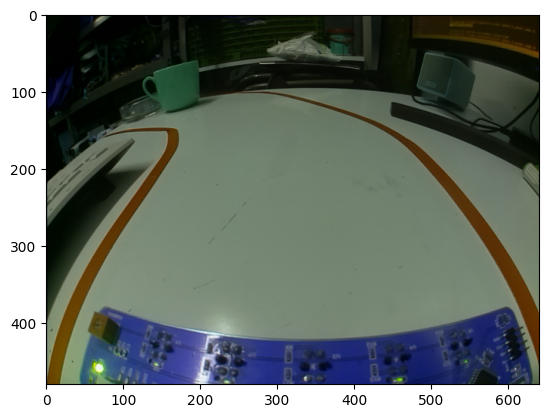

In [56]:
plt.imshow(img)             # Zeigt das Bild in BGR
print(img.shape)            # Zeigt das Bildformat

(480, 640, 3)


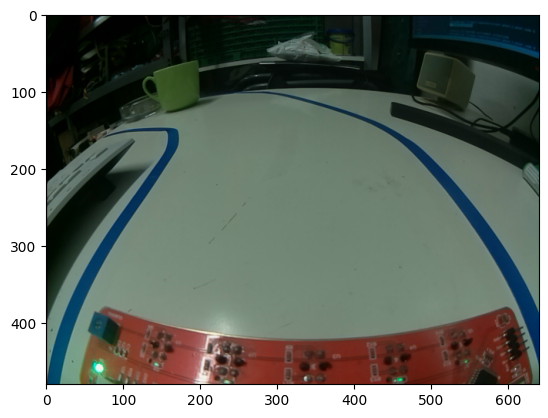

In [57]:
img_RGB = cv.cvtColor(img,cv.COLOR_BGR2RGB)     #Hier wird das Bild in RGB umgewandelt

plt.imshow(img_RGB)                             # Darstellung des Bildes in RGB

print(img_RGB.shape)

(300, 640, 3)


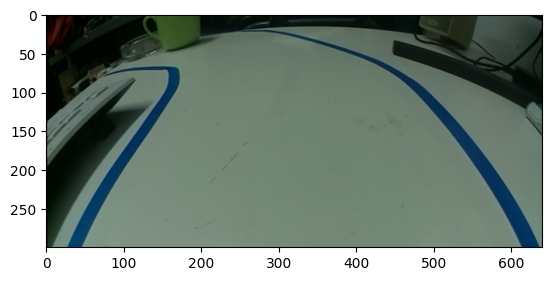

In [58]:
img_cut = img_RGB[80:380,0:640].copy()         #Legt eine Kopie an und schneidet das bild aus

plt.imshow(img_cut)

print(img_cut.shape)

(300, 640, 3)


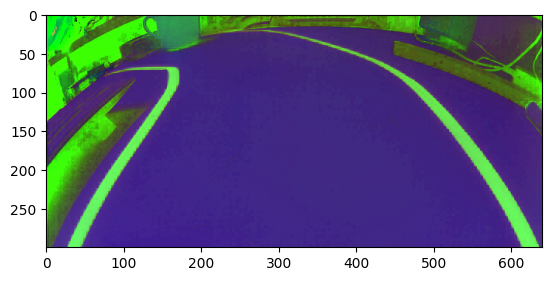

In [59]:
img_cut_HSV = cv.cvtColor(img_cut,cv.COLOR_RGB2HSV)     # Wandelt das bild in HSV

plt.imshow(img_cut_HSV)

print(img_cut_HSV.shape)

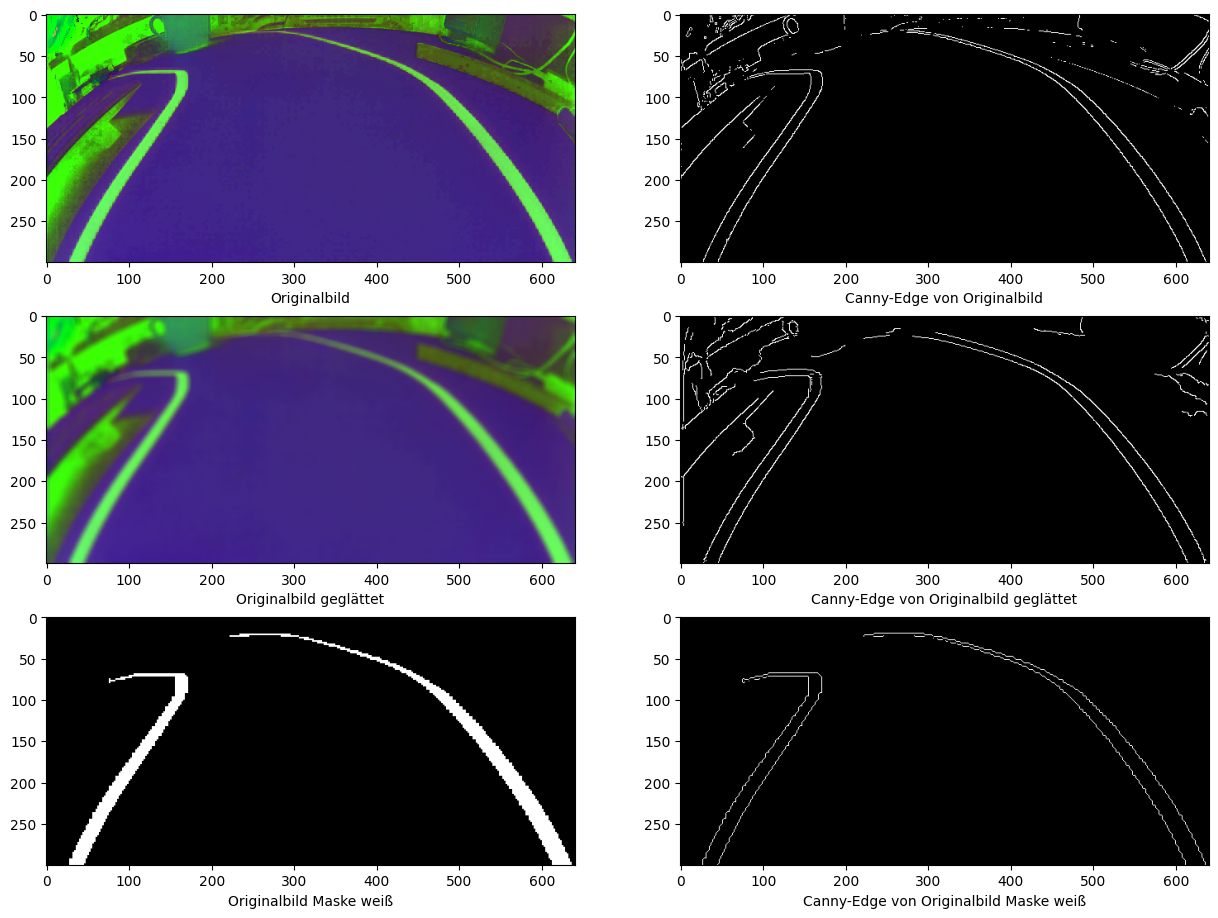

In [60]:


from PIL import Image


image = img_cut_HSV

image_blur= cv.blur(image,(8,8))

lower = np.array([95, 0, 0])
upper = np.array([120, 255, 255])
image_mask = cv.inRange(image, lower, upper)

plt.figure(figsize=(15,15))
plt.subplot(421)
plt.xlabel('Originalbild')
plt.imshow(image)

plt.subplot(422)
plt.xlabel('Canny-Edge von Originalbild')
plt.imshow(cv.Canny(image,440,450),cmap='gray')

plt.subplot(423)
plt.xlabel('Originalbild geglättet')
plt.imshow(image_blur,cmap='gray')

plt.subplot(424)
plt.xlabel('Canny-Edge von Originalbild geglättet')
plt.imshow(cv.Canny(image_blur,100,150),cmap='gray')

plt.subplot(425)
plt.xlabel('Originalbild Maske weiß')
plt.imshow(image_mask,cmap='gray')

plt.subplot(426)
image_edges = cv.Canny(image_mask,440,450)
plt.xlabel('Canny-Edge von Originalbild Maske weiß')
plt.imshow(image_edges,cmap='gray')

In [61]:
# Klassische Hough-Transformation
image_mask = cv.inRange(image, lower, upper)

rho = 1  # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold =  220 # minimal of votes, Je geringer Min_threshold, dest mehr Geraden werden erkannt. 

parameter_mask = cv.HoughLines(image_mask, rho, angle, min_threshold)

print(parameter_mask.shape)     # am besten hier so wenig pixel wie möglich geändert wird dies über min_threshold
parameter_mask[:2]

(28, 1, 2)


array([[[183.        ,   0.55850536]],

       [[185.        ,   0.55850536]]], dtype=float32)

In [91]:
def draw_lines(parameter_mask,img):
    lines_left_y1 = np.array([])
    lines_left_y2 = np.array([])
    lines_right_y1 = np.array([])
    lines_right_y2 = np.array([])

    img2 = img.copy()
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
    for line in parameter_mask:
        rho,theta = line[0]
        try:
            a = -np.cos(theta)/np.sin(theta) # Anstieg der Gerade
            b = rho/np.sin(theta)            # Absolutglied/Intercept/Schnittpunkt mit der y-Achse
            x1 = 0
            y1 = int(b)
            x2 = 1000
            y2 = int(a*1000+b)

            if y1 > 0 :
                lines_left_y1 = np.append(lines_left_y1,[y1])
                lines_left_y2 = np.append(lines_left_y2,[y2])
            if y1 < 0 :
                lines_right_y1 = np.append(lines_right_y1,[y1])
                lines_right_y2 = np.append(lines_right_y2,[y2])


        except:
            #print(f'Fehler{a,b}')
            pass
        #print(x1,x2,y1,y2)

        img2=cv.line(img2,(x1,y1),(x2,y2),(200,100,100),1) # adds a line to an image
        cv.putText(img2, 
            text = 'erkannte Geraden',
            org=(180,190), # Position
            fontFace= cv.FONT_HERSHEY_SIMPLEX,
            fontScale = .8, # Font size
            color = (255,247,0), # Color in rgb
            thickness = 2)
        
            

    left_y1_r = round(lines_left_y1.mean(),0) 
    left_y2_r = round(lines_left_y2.mean(),0) 
    right_y1_r = round(lines_right_y1.mean(),0) 
    right_y2_r = round(lines_right_y2.mean(),0) 
    print(left_y1_r,left_y2_r,right_y1_r,right_y2_r)

    img2=cv.line(img2,(x1,int(left_y1_r)),(x2,int(left_y2_r)),(0,0,255),3)
    img2=cv.line(img2,(x1,int(right_y1_r)),(x2,int(right_y2_r)),(0,0,255),3)

    

    return img2

imageresult =  draw_lines(parameter_mask, image_mask)    

351.0 -1282.0 -532.0 766.0


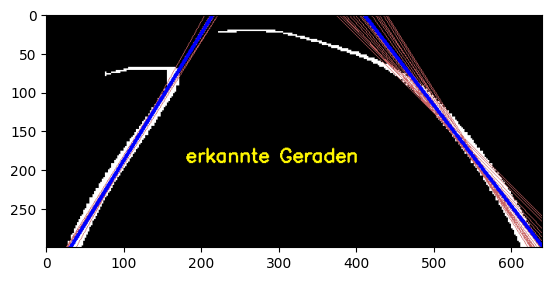

In [92]:
plt.imshow(imageresult)

In [12]:
# Probabilistische Hough-Transformation

image_mask = cv.inRange(image, lower, upper)
image_edges = cv.Canny(image_mask,200,400)
rho = 1              # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 100   # in etwas Anzal der Punkt auf der Geraden. Je geringer Min_threshold, desto mehr Geraden werden erkannt.
minLineLength = 8    # Minimale Linienlänge
maxLineGap = 4       # Maximale Anzahl von Lücken in der Linie

line_segments = cv.HoughLinesP(image_mask, rho, angle, min_threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)
print(line_segments.shape)
# Elemente stellen Punkte des Liniensegmentes dar (x1,y1,x2,y2)
line_segments[:2]

(43, 1, 4)


array([[[442, 100, 589, 296]],

       [[435,  96, 583, 299]]], dtype=int32)

1 117 299 80


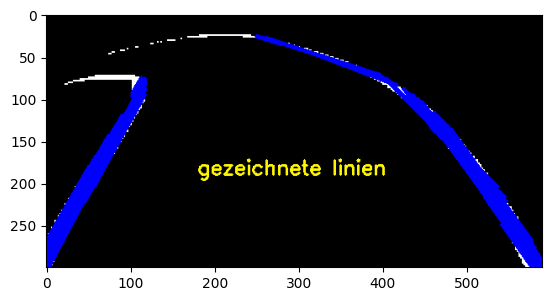

In [14]:
def draw_line_segments(line_segments,img):
    img2 = img.copy()
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
    for line in line_segments:
        x1,y1,x2,y2 = line[0]
        cv.line(img2,(x1,y1),(x2,y2),(0,0,255),3)

    cv.putText(img2, 
            text = 'gezeichnete linien',
            org=(180,190), # Position
            fontFace= cv.FONT_HERSHEY_SIMPLEX,
            fontScale = .8, # Font size
            color = (255,247,0), # Color in rgb
            thickness = 2)
    print(x1,x2,y1,y2)
    return img2

image_result1 = draw_line_segments(line_segments,image_mask)

plt.imshow(image_result1)

In [14]:
def draw_line_segments(line_segments,img):
    img2 = img.copy()
    #img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
    if line_segments is not None: # Könnte None sein, wenn Hough keine Linie erkennt!
        for line in line_segments:
            x1,y1,x2,y2 = line[0]
            cv.line(img2,(x1,y1),(x2,y2),(0,0,255),3)
    return img2

# Erstellen eines Objektes für den Kamerazugriff
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

# Parameter canny
maxVal=150
minVal=50
# Parameter Hough
rho = 1              # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 70   # in etwas Anzal der Punkt auf der Geraden. Je geringer Min_threshold, dest mehr Geraden werden erkannt.
minLineLength = 30   # Minimale Linienlänge
maxLineGap = 10       # Maximale Anzahl von Lücken in der Linie
# Parameter Test
f = cv.FONT_HERSHEY_SIMPLEX
c = (0,255,255)

# Schleife für Video Capturing
while True:
    # Abfrage eines Frames
    ret, frame = cap.read()
    height, width, _ = frame.shape
    frame = cv.resize(frame,(int(width*2/3), int(height*2/3)), interpolation = cv.INTER_CUBIC)
    # Wenn ret == TRUE, so war Abfrage erfolgreich
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Bildmanipulation ----------
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_canny = cv.Canny(frame_gray,maxVal,maxVal)
    line_segments = cv.HoughLinesP(frame_canny, rho, angle, min_threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)
    frame_ls = draw_line_segments(line_segments,frame)
    frame_to_display = np.hstack((frame,frame_ls)) # Numpy-Operationen sind auch möglich!

    frame_gray_blurred=cv.blur(frame_gray,(5,5))
    frame_to_display_additional = np.hstack((frame_gray_blurred,frame_canny))
    frame_to_display_additional = cv.cvtColor(frame_to_display_additional, cv.COLOR_GRAY2BGR)

    frame_to_display_final = np.vstack((frame_to_display,frame_to_display_additional))
    cv.putText(frame_to_display_final, text = 'Original', org=(10,303), fontFace= f,fontScale = .5, color = c, thickness = 1)
    cv.putText(frame_to_display_final, text = 'Graustufen mit Smoothing', org=(10,616), fontFace= f,fontScale = .5, color = c, thickness = 1)
    cv.putText(frame_to_display_final, text = 'Hough-Liniensegmente', org=(445,303), fontFace= f,fontScale = .5, color = c, thickness = 1)
    cv.putText(frame_to_display_final, text = 'Canny-Kantenerkennung', org=(445,616), fontFace= f,fontScale = .5, color = c, thickness = 1)
    
    # ---------------------------
    # Alternative:
    # frame_to_display = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # ---------------------------
    # Display des Frames
    cv.imshow("Display window (press q to quit)", frame_to_display_final)
    # Ende bei Drücken der Taste q
    if cv.waitKey(1) == ord('q'):
        break
# Kamera-Objekt muss "released" werden, um "später" ein neues Kamera-Objekt erstellen zu können!!!
cap.release()
cv.destroyAllWindows()